# Thetis Calibration Script

## Section 0: Imports and global function definitions

In [154]:
"""
ChatGPT Conversation:   https://chat.openai.com/c/ef545f4e-6aa6-4598-8c37-371934ac2cd9
                        https://chat.openai.com/c/55ac6d8d-8591-43f0-b7a5-d36e088d83aa
"""

import os
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages  # Add this import
from scipy.stats import pearsonr 

# Define the input and output directories
CALIBRATION_DATA_ROOT_DIR   = "C:/Users/bduffy2018/OneDrive - Florida Institute of Technology/School/Thesis/Experiments/Calibration/x-IMU3"
RAW_OUTPUT_PATH             = 'output/raw/'
PRELIMINARY_OUTPUT_PATH     = 'output/prelim/'
INTERMEDIATE_OUTPUT_PATH    = 'output/intermediate/'
FINAL_OUTPUT_PATH           = 'output/final/'

# Define the size of series windows
SAMPLE_RATE         = 50                            # Data captured at ~F Hz sample rate
WINDOW_SIZE_SEC     = 10                            # Capture ~N-seconds of data
WINDOW_SIZE = SAMPLE_RATE * WINDOW_SIZE_SEC # Calculate number of indexes required for the window


def RMSE(time_series: np.ndarray, ground_truth: float) -> float:
    """Returns the root-mean-square-error between a time series and a ground truth over the entire series

    Args:
        time_series (np.ndarray): The measurement time series
        ground_truth (float): The ground truth, "real" value that is compared against

    Returns:
        float: the RMSE between the time series and the ground truth
    """
    return np.sqrt(np.mean((time_series - ground_truth) ** 2))


def RMSE(arr1: np.ndarray, arr2: np.ndarray) -> float:
    """Returns the root-mean-square-error between two arrays

    Args:
        arr1 (np.ndarray): Input array 
        arr2 (np.ndarray): Input array

    Returns:
        float: the RMSE between the two arrays
    """
    return np.sqrt(np.mean((arr1 - arr2) ** 2))


def reject_outliers(data, a, timestamps, m = 2.) -> np.ndarray:
    """Removes outliers from a data time series based on distance from the standard deviation of the entire dataset

    Args:
        data (np.ndarray): the data series to be evaluated
        timestamps (np.ndarray): the timestamps the correlate with the data series
        m (int, optional): The threshold in standard deviations for removing outliers. Defaults to 2..

    Returns:
        np.ndarray, np.ndarray: The original data time series sans any outliers
    """
    z_score = np.abs(data - np.mean(data, axis=0)[a]) / np.std(data, axis=0)[a]
    # print(z_score)
    return data, timestamps


def down_sample_average(data: np.array, n: int=2) -> np.array:
    """Down samples a data array by a factor.
    For example, if data is a time series sampled at 100 Hz, down_sample_average(data)
    will return the array averaged to 50 Hz.

    Args:
        data (np.array): The time series data to be modified
        n (int): the factor of reduction. 2 for half rate, 3 for third, etc. Defaults to 2

    Returns:
        np.array: The down sampled array
    """
    end = n * int(len(data)/n)
    return np.mean(data[:end].reshape(-1, n), axis=1)


# Initialize an empty list to store the sensor information
calibration_data = []


# Iterate through the directories
for sensor_dir in os.listdir(CALIBRATION_DATA_ROOT_DIR):
    sensor_name, axis, ground_truth_name = sensor_dir.split("_")
    
    # Process sensor names and units into a more ingestible format
    if sensor_name == "accel":
        sensor_name = "Accelerometer"
        y_label = "Acceleration"
        unit = "g"
        
        if axis == "x-axis":
            ground_truth_value = -1 * math.cos(math.radians(float(ground_truth_name)))
        elif axis == "y-axis":
            ground_truth_value = 1 * math.cos(math.radians(float(ground_truth_name)))
        elif axis == "z-axis":
            ground_truth_value = -1 * math.cos(math.radians(float(ground_truth_name)))
            
        ground_truth_name += " degrees"
            
    elif sensor_name == "gyro":
        sensor_name = "Gyroscope"
        y_label = "Rotation Rate"
        unit = "deg/s"
        ground_truth_value = float(ground_truth_name)
        ground_truth_name = f"{abs(ground_truth_value)} {unit} CCW" if ground_truth_value < 0 else f"{abs(ground_truth_value)} {unit} CW"
        
        
    axis = axis[0].capitalize()
    
    # Initialize a dictionary to store the sensor information
    calibration_dataset = {
        "sensor_name": sensor_name,
        "axis": axis,
        "ground_truth_name": ground_truth_name,
        "ground_truth_value": ground_truth_value,
        "devices": [],
        "device_deviation": None,
        "y_label": y_label,
        "unit": unit,
        "output_name": sensor_dir
    }

    # Iterate through the device directories
    device_dir = os.path.join(CALIBRATION_DATA_ROOT_DIR, sensor_dir)
    for device_dir_name in os.listdir(device_dir):
        # print(device_dir_name.split())
        device_name = device_dir_name.split()[0]
        inertial_csv_path = os.path.join(device_dir, device_dir_name, "Inertial.csv")
        
        # Append the device information to the sensor dictionary
        calibration_dataset["devices"].append({
            "device_name": device_name,
            "inertial_csv_path": inertial_csv_path,
            "cleaned_time": None,
            "cleaned_data": None,
            "window_start": None,
            "window_end": None,
            "windowed_time": None,
            "windowed_data": None,
            "ground_truth_deviation": None
        })

    # Append the sensor dictionary to the list
    calibration_data.append(calibration_dataset)

## Section 1: Windowing the Raw Data
Here, we will process the raw data into windows that are more usable for future calculations. We will also create plots of the raw data with the windows represented.

-1.015318720852765
0.0015596135311182777


IndexError: invalid index to scalar variable.

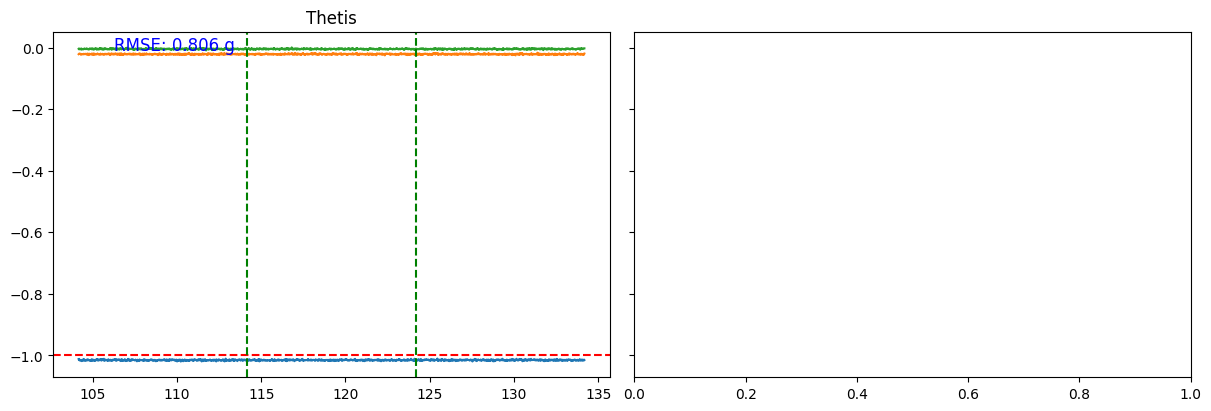

In [155]:
for calibration_dataset in calibration_data:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), layout='constrained', sharey=True)
    
    for i, device in enumerate(calibration_dataset["devices"]):
        
        # ========================================
        # == Clean The Raw Data For Each Device ==
        # ========================================
    
        # Load the CSV data into a DataFrame
        df = pd.read_csv(device["inertial_csv_path"])
        
        timestamps = df["Timestamp (us)"].to_numpy() / 1e6
        data = df[[f"{calibration_dataset['sensor_name']} X ({calibration_dataset['unit']})",
                  f"{calibration_dataset['sensor_name']} Y ({calibration_dataset['unit']})",
                  f"{calibration_dataset['sensor_name']} Z ({calibration_dataset['unit']})"]].to_numpy()
        
        if device['device_name'] == "x-IMU3": # Downsample x-IMU3 data to 100 Hz
            data = down_sample_average(data)
            timestamps = down_sample_average(timestamps)
            
        # print(data)
        print(np.mean(data, axis=0)[0])
        print(np.std(data, axis=0)[0])
        
        data, timestamps = reject_outliers(data, 0, timestamps)
        
        device["cleaned_time"] = timestamps
        device["cleaned_data"] = data
        
        device["window_start"]  = int(len(data)/2) - int(WINDOW_SIZE/2)
        device["window_end"]    = device["window_start"] + WINDOW_SIZE
        device["windowed_data"] = data[device["window_start"]:device["window_end"]]        
    
        # ======================================================
        # == Create Plots of the Raw Data with Windows Marked ==
        # ======================================================
        
        ax = axes[i]
    
        # Plot the data on the respective subplot
        ax.plot(timestamps, data)

        # Plot the ground truth value
        ax.axhline(y=calibration_dataset['ground_truth_value'], color='r', linestyle='--')
        
        # Plot the window bounds
        ax.axvline(x=timestamps[device["window_start"]], color='g', linestyle='--')
        ax.axvline(x=timestamps[device["window_end"]], color='g', linestyle='--')
        
        # Add a label for the RMSE
        device['ground_truth_deviation'] = RMSE(data, calibration_dataset['ground_truth_value'])
        fig.text(0.09+0.78*i, 0.9, f"RMSE: {device['ground_truth_deviation']:0.3f} {calibration_dataset['unit']}", fontsize=12, color='blue', va='center', ha='left')
        
        # Set individual plot title
        ax.set_title(f"{device['device_name']}")
    
    # Calculate deviation of Thetis from x-IMU3 window data
    calibration_dataset["device_deviation"] = RMSE(calibration_dataset["devices"][0]["windowed_data"], calibration_dataset["devices"][1]["windowed_data"])
        
    # =====================================================
    # == Finish Creating The Raw Figure for Each Dataset ==
    # =====================================================      
        
    # Set the title and labels for the whole figure
    fig.suptitle(f"{calibration_dataset['sensor_name']} {calibration_dataset['axis']} | {calibration_dataset['ground_truth_name']}")
    fig.text(0.5, 0.9, f"Thetis Deviation from x-IMU3: {calibration_dataset['device_deviation']:0.3f} {calibration_dataset['unit']}", ha='center')
    fig.supxlabel("Timestamp (s)")
    fig.supylabel(f"{calibration_dataset['y_label']} ({calibration_dataset['unit']})")
    
    # Save figure to files
    FIG_OUTPUT_PATH = RAW_OUTPUT_PATH + f"raw_{calibration_dataset['output_name']}.png"
    if not os.path.exists(FIG_OUTPUT_PATH): # Check if output already exists to save execution time
        fig.savefig(FIG_OUTPUT_PATH)
    
    # Close the figure to save memory
    plt.close(fig)

## Section 2: Plot MSE as a Function of Ground Truth
Create two figures with three plots each. One figure for accelerometer, one for gyroscope. Each plot will be MSE as a function of the test value. One plot will be x-IMU3 wrt ground truth, the second plot will be Thetis wrt x-IMU3, and the final plot will be Thetis wrt the ground truth.

In [111]:
# Create figure for accelerometer error
fig_accel, axes_accel = plt.subplots(1, 3, figsize=(18, 4), layout='constrained', sharey=True, sharex=True)

# Create figure for gyroscope error
fig_gyro, axes_gyro = plt.subplots(1, 3, figsize=(18, 4), layout='constrained', sharey=True, sharex=True)

calibration_errors = [{
    "sensor_name": dataset["sensor_name"],
    "axis": dataset["axis"],
    "ground_truth_value": float(dataset["ground_truth_name"].split(" ")[0]) if dataset["sensor_name"] == "Accelerometer" else dataset["ground_truth_value"], 
    "thetis_ximu3_deviation": dataset["device_deviation"], 
    "thetis_ground_deviation": dataset["devices"][0]["ground_truth_deviation"], 
    "ximu3_ground_deviation": dataset["devices"][1]["ground_truth_deviation"]}
    for dataset in calibration_data]
print(calibration_errors)

def sort_ascending(x_values, y_values):
    combined = list(zip(x_values, y_values))
    sorted_combined = sorted(combined, key=lambda x: x[0])
    return zip(*sorted_combined)

# ===============================
# == Plot Accelerometer Errors ==
# ===============================

for i, ax in enumerate(axes_accel):
    if i == 0: # x-IMU3 w.r.t Ground Truth
        for axis in ["X", "Y", "Z"]:
            x_values = [item["ground_truth_value"] for item in calibration_errors if item["sensor_name"] == "Accelerometer" and item["axis"] == axis]
            errors = [item["ximu3_ground_deviation"] * 1e3 for item in calibration_errors if item["sensor_name"] == "Accelerometer" and item["axis"] == axis]
            x_sorted, errors_sorted = sort_ascending(x_values, errors)
            ax.plot(x_sorted, errors_sorted, label=axis)
        ax.set_title("x-IMU3 w.r.t Ground Truth")

    if i == 1: # Thetis w.r.t x-IMU3
        for axis in ["X", "Y", "Z"]:
            x_values = [item["ground_truth_value"] for item in calibration_errors if item["sensor_name"] == "Accelerometer" and item["axis"] == axis]
            errors = [item["thetis_ximu3_deviation"] * 1e3 for item in calibration_errors if item["sensor_name"] == "Accelerometer" and item["axis"] == axis]
            x_sorted, errors_sorted = sort_ascending(x_values, errors)
            ax.plot(x_sorted, errors_sorted, label=axis)
        ax.set_title("Thetis w.r.t x-IMU3")
            
    if i == 2: # Thetis w.r.t Ground Truth
        for axis in ["X", "Y", "Z"]:
            x_values = [item["ground_truth_value"] for item in calibration_errors if item["sensor_name"] == "Accelerometer" and item["axis"] == axis]
            errors = [item["thetis_ground_deviation"] * 1e3 for item in calibration_errors if item["sensor_name"] == "Accelerometer" and item["axis"] == axis]
            x_sorted, errors_sorted = sort_ascending(x_values, errors)
            ax.plot(x_sorted, errors_sorted, label=axis)
        ax.set_title("Thetis w.r.t Ground Truth")
    ax.grid()
    ax.legend()
    
fig_accel.suptitle("Accelerometer Error")
fig_accel.supylabel("Error (mg)")
fig_accel.supxlabel("Angle (deg)")

# ===========================
# == Plot Gyroscope Errors ==
# ===========================

for i, ax in enumerate(axes_gyro):
    if i == 0: # x-IMU3 w.r.t Ground Truth
        for axis in ["X", "Y", "Z"]:
            x_values = [item["ground_truth_value"] for item in calibration_errors if item["sensor_name"] == "Gyroscope" and item["axis"] == axis]
            errors = [item["ximu3_ground_deviation"] for item in calibration_errors if item["sensor_name"] == "Gyroscope" and item["axis"] == axis]
            x_sorted, errors_sorted = sort_ascending(x_values, errors)
            ax.plot(x_sorted, errors_sorted, label=axis)
        ax.set_title("x-IMU3 w.r.t Ground Truth")

    if i == 1: # Thetis w.r.t x-IMU3
        for axis in ["X", "Y", "Z"]:
            x_values = [item["ground_truth_value"] for item in calibration_errors if item["sensor_name"] == "Gyroscope" and item["axis"] == axis]
            errors = [item["thetis_ximu3_deviation"] for item in calibration_errors if item["sensor_name"] == "Gyroscope" and item["axis"] == axis]
            x_sorted, errors_sorted = sort_ascending(x_values, errors)
            ax.plot(x_sorted, errors_sorted, label=axis)
        ax.set_title("Thetis w.r.t x-IMU3")
            
    if i == 2: # Thetis w.r.t Ground Truth
        for axis in ["X", "Y", "Z"]:
            x_values = [item["ground_truth_value"] for item in calibration_errors if item["sensor_name"] == "Gyroscope" and item["axis"] == axis]
            errors = [item["thetis_ground_deviation"] for item in calibration_errors if item["sensor_name"] == "Gyroscope" and item["axis"] == axis]
            x_sorted, errors_sorted = sort_ascending(x_values, errors)
            ax.plot(x_sorted, errors_sorted, label=axis)
        ax.set_title("Thetis w.r.t Ground Truth")
    ax.tick_params(axis='y')
    ax.grid()
    ax.legend()
    
fig_gyro.suptitle("Gyroscope Error")
fig_gyro.supylabel("Error (deg/sec)")
fig_gyro.supxlabel("Angular Velocity (deg/sec)")

# ===========================
# == Save Figures to Files ==
# ===========================

# plt.show() # Debug

FIG_OUTPUT_PATH = PRELIMINARY_OUTPUT_PATH + "prelim_accel.png"
if not os.path.exists(FIG_OUTPUT_PATH): # Check if output already exists to save execution time
    fig_accel.savefig(FIG_OUTPUT_PATH)
    
FIG_OUTPUT_PATH = PRELIMINARY_OUTPUT_PATH + "prelim_gyro.png"
if not os.path.exists(FIG_OUTPUT_PATH): # Check if output already exists to save execution time
    fig_gyro.savefig(FIG_OUTPUT_PATH)

# Close the figures to save memory
plt.close(fig_accel)
plt.close(fig_gyro)

[{'sensor_name': 'Accelerometer', 'axis': 'X', 'ground_truth_value': 0.0, 'thetis_ximu3_deviation': 0.020568558677481516, 'thetis_ground_deviation': 0.01539627267939551, 'ximu3_ground_deviation': 0.005184918366764168}, {'sensor_name': 'Accelerometer', 'axis': 'X', 'ground_truth_value': 135.0, 'thetis_ximu3_deviation': 0.006747883905677397, 'thetis_ground_deviation': 0.017301438004962293, 'ximu3_ground_deviation': 0.010667658367905104}, {'sensor_name': 'Accelerometer', 'axis': 'X', 'ground_truth_value': 180.0, 'thetis_ximu3_deviation': 0.011786402305601991, 'thetis_ground_deviation': 0.011618283150577944, 'ximu3_ground_deviation': 0.0007637990568019164}, {'sensor_name': 'Accelerometer', 'axis': 'X', 'ground_truth_value': 225.0, 'thetis_ximu3_deviation': 0.016942349755878012, 'thetis_ground_deviation': 0.0075385287008642105, 'ximu3_ground_deviation': 0.00938623150678163}, {'sensor_name': 'Accelerometer', 'axis': 'X', 'ground_truth_value': 270.0, 'thetis_ximu3_deviation': 0.01401774865798

## Section 3: Calculate Calibration Parameters

In order to calibrate a MARG array, we need to create a model of the data. For the accelerometer and gyroscope, we can create an inertial model defined as:

$$
\vec{i}_c=MS(\vec{i}_u-\vec{b}) \\
\begin{align*}
\\
\text{where } & \vec{i}_C \text{ is the calibrated inertial measurements,} \\ 
& M \text{ is the misalignment matrix,} \\
& S \text{ is the sensitivity identity matrix,} \\
& \vec{i}_u \text{ is the uncalibrated inertial measurements, and} \\
& \vec{b} \text{ is the bias or offset vector}
\end{align*}
$$

The three calibration values, $M$, $S$, $b$, represent a set of correction factors that make the measured values more accurate. The inertial measurement is generalized here to represent either accelerometer or gyroscope data. Each sensor will have its own set of the calibration values.

### Bias Vector

The bias, or offset, vector is the average of the inertial readings while the sensor is in a stable, known orientation. For example, when the gyroscope is at rest, we would expect the measurement output to be $[0,0,0] \text{ [deg/sec]}$. However, we may measure an average of $[0.89, -0.66, 0.31] \text{ [deg/sec]}$ instead. By subtracting this bias vector from the measurements, we eliminate any unintentional offset from our readings. The bias can be calculated using the equation below:

$$
\vec{b}_g = \frac{1}{N} \sum_{i=0}^N{\vec{g}_n} \\
\begin{align*}
\\
\text{where } & \vec{b}_g \text{ is the bias vector,} \\
& N \text{ is the number of collected samples to average, and} \\
& \vec{g}_n \text{ is the n-th uncalibrated gyroscope measurement vector in the dataset}
\end{align*}
$$

For accelerometers, the bias is calculated differently. Each measurement axis must be exposed to ±1g of acceleration by placing the instrument vertical on each of the measurement axes in both the positive and negative directions. The bias for each axis can then be determined by taking the average value as shown below:

$$
\vec{b}_a = \frac{1}{2} \left[ \frac{1}{N}\sum_{n=0}^N{\vec{a}_{n,+g}} + \frac{1}{M}\sum_{m=0}^M{\vec{a}_{m_-g}} \right] \\

\begin{align*}
\\ \text{where } & b_a \text{ is the bias vector,} \\
& N \text{ is the number of samples taken in the +1g orientation,} \\
& a_{+g} \text{ is the average axis measurement when exposed to +1g, and}\\
& M \text{ is the number of samples taken in the -1g orientation,} \\
& a_{-g} \text{ is the average axis measurement when exposed to -1g}
\end{align*}
$$

### Sensitivity Matrix

The sensitivity matrix is a diagonal matrix that accounts for minor errors with variations in process and material. This can make each uniaxial sensor in a triaxial array sense the environment slightly differently. While bias covers this area when at rest or in specific orientations, the sensitivity error will change depending on the motion and orientation. To account for this, we need to expose each sensor to a known reference stimulus and calculate a sensitivity value based on the average magnitude of the measurement vector during that time. For a gyroscope, this value can be an arbitrary, but constant, rotation rate, $\omega$. For an accelerometer, this value will be ±1g. The equations for each gyroscope and accelerometer axis are provided below:

$$
s_{g, \omega} = \frac{\lVert g_{+\omega}\rVert + \lVert g_{-\omega}\rVert}{2\omega} \\
\begin{align*}
\\ \text{where } & s_{g,\omega} \text{ is the sensitivity value for each gyroscope axis when exposed to } \omega , \\
& g_{+\omega } \text{ is the average gyroscope axis reading whe exposed to +} \omega ,\\
& g_{-\omega } \text{ is the average gyroscope axis reading whe exposed to -} \omega , \text{ and} \\
& \omega \text{ is the reference roation rate}
\end{align*}
$$

$$
s_{a, g} = \frac{\lVert a_{+g} \rVert + \lVert a_{-g} \rVert}{2} \\
\begin{align*}
\\ \text{where } & s_{a,g} \text{ is the sensitivity value for each axis when exposed to 1g,} \\
& a_{+g} \text{ is the average axis measurement when exposed to +1g, and} \\
& a_{-g} \text{ is the average axis measurement when exposed to -1g}
\end{align*}
$$

After calculating these values for each axis, we can form the sensitivity matrix for the gyroscope and accelerometer like so:

$$
S_g = 
\begin{bmatrix}
s_{g,x} & 0 & 0 \\
0 & s_{g,y} & 0 \\
0 & 0 & s_{g,z}
\end{bmatrix} 
$$

$$
S_a =
\begin{bmatrix}
s_{a,x} & 0 & 0 \\
0 & s_{a,y} & 0 \\
0 & 0 & s_{a,z}
\end{bmatrix}
$$

While this calibration value accounts for some of the intrinsic sensor error, it does not account for axes misalignment or non-orthogonality within the sensor. To accomplish this, we must incorporate the misalignment matrix.

### Misalignment Matrix

The misalignment matrix is the final, but most complex, calibration value that we can calculate for the inertial sensors. It reduces error from multiple sources such as non-orthogonality between the measurement axes, the misalignment from the measurement axes to the actual sensor packaging, and misalignment from the package onto the application board. In order to calculate the misalignment matrix, we must consider it as the solution to a non-linear problem. First, we must define an objective function for the solution space. Since the goal of the misalignment matrix is to reduce error, then we can define the objective function as the Root Mean Square Error (RMSE) of the measurement vector, the misalignment vector, and the reference vector:

$$
RMSE = \sqrt{\frac{1}{N}\sum_{n=0}^N{\|{\vec{i}_{n,u} \cdot M^* -\vec{i}_{n,ref}\|}^2}} \\

\begin{align*}
\\ \text{where } & N \text{ is the number of samples in the dataset,} \\
& \vec{i}_{n,u} \text{ is the n-th uncalibrated measurement vector with the bias removed,} \\
& M^* \text{ is the guessed 3-by-3 matrix that corrects $i_{n,u}$ to be near $i_{ref}$, and } \\
& \vec{i}_{ref} \text{ is the expected reference stimulus vector for the measurement}
\end{align*}
$$

Then, given a dataset of measurement vectors and their expected reference vectors, we can use a non-liner solver to determine the value of $M^*$. This can be done using the `scipy.optimize.minimize` toolbox which black boxes the process, but provides an easy to work with output for future processing. Assuming the sensitivity was not removed from the measurement signal, the $M^*$ matrix happens to include it as its diagonal. By extracting the diagonal and normalizing the original matrix, we are left with the sensitivity and misalignment matrix calibration values.

$$
S = \text{diag}(M^*) \\
M=M^* \cdot S^{-1}
$$

We can now apply the misalignment matrix, sensitivity matrix, and bias vector to the sensor readings according to the model above. This should yield outputs that are close to the real values, which is examined in the next section.

In [136]:
def grab_sensor_data(sensor_name, axis):
    return np.concatenate([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == sensor_name and dataset["axis"] == axis])


def generate_reference_data(sensor_name, axis):
    return np.concatenate([np.ones(len(dataset["devices"][0]["cleaned_data"])) * dataset["ground_truth_value"] for dataset in calibration_data if dataset["sensor_name"] == sensor_name and dataset["axis"] == axis])


accel_data_x = grab_sensor_data("Accelerometer", "X")
accel_data_y = grab_sensor_data("Accelerometer", "Y")
accel_data_z = grab_sensor_data("Accelerometer", "Z")
gyro_data_x = grab_sensor_data("Gyroscope", "X")
gyro_data_y = grab_sensor_data("Gyroscope", "Y")
gyro_data_z = grab_sensor_data("Gyroscope", "Z")

accel_ref_x = generate_reference_data("Accelerometer", "X")
accel_ref_y = generate_reference_data("Accelerometer", "X")
accel_ref_z = generate_reference_data("Accelerometer", "X")
gyro_ref_x = generate_reference_data("Gyroscope", "X")
gyro_ref_y = generate_reference_data("Gyroscope", "Y")
gyro_ref_z = generate_reference_data("Gyroscope", "Z")

accel_end = min((len(accel_data_x), len(accel_data_y), len(accel_data_z)))
accel_data = np.vstack((accel_data_x[:accel_end], accel_data_y[:accel_end], accel_data_z[:accel_end]))
accel_ref = np.vstack((accel_ref_x[:accel_end], accel_ref_y[:accel_end], accel_ref_z[:accel_end]))
# print(accel_data)

gyro_end = min((len(gyro_data_x), len(gyro_data_y), len(gyro_data_z)))
gyro_data = np.vstack((gyro_data_x[:gyro_end], gyro_data_y[:gyro_end], gyro_data_z[:gyro_end]))
gyro_ref = np.vstack((gyro_ref_x[:gyro_end], gyro_ref_y[:gyro_end], gyro_ref_z[:gyro_end]))
# print(gyro_data)

# ==========================================
# == Calculate Bias for the Accelerometer ==
# ==========================================

accel_data_p1g_x = np.concatenate([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Accelerometer" and dataset["axis"] == "X" and dataset["ground_truth_value"] == 1.0])
accel_data_p1g_y = np.concatenate([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Accelerometer" and dataset["axis"] == "Y" and dataset["ground_truth_value"] == 1.0])
accel_data_p1g_z = np.concatenate([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Accelerometer" and dataset["axis"] == "Z" and dataset["ground_truth_value"] == 1.0])
accel_data_m1g_x = np.concatenate([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Accelerometer" and dataset["axis"] == "X" and dataset["ground_truth_value"] == -1.0])
accel_data_m1g_y = np.concatenate([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Accelerometer" and dataset["axis"] == "Y" and dataset["ground_truth_value"] == -1.0])
accel_data_m1g_z = np.concatenate([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Accelerometer" and dataset["axis"] == "Z" and dataset["ground_truth_value"] == -1.0])

p1g_end = min((len(accel_data_p1g_x), len(accel_data_p1g_y), len(accel_data_p1g_z)))
accel_data_p1g = np.vstack((accel_data_p1g_x[:p1g_end], accel_data_p1g_y[:p1g_end], accel_data_p1g_z[:p1g_end]))
m1g_end = min((len(accel_data_m1g_x), len(accel_data_m1g_y), len(accel_data_m1g_z)))
accel_data_m1g = np.vstack((accel_data_m1g_x[:m1g_end], accel_data_m1g_y[:m1g_end], accel_data_m1g_z[:m1g_end]))
print(accel_data_p1g)
print(accel_data_m1g)

bias = (np.mean(accel_data_p1g, axis=1) + np.mean(accel_data_m1g, axis=1)) / 2
print(bias)

import sys
sys.exit(1)

# Subtract bias from each vector in I_u_list
for i in range(num_samples):
    I_u_list[i] -= bias

# Define the loss functions
def mse_loss(M_flattened):
    M = M_flattened.reshape((3, 3))
    total_loss = 0.0
    
    for i in range(num_samples):
        difference = np.dot(I_u_list[i], M) - I_ref_list[i]
        mse = np.sum(difference**2)
        total_loss += mse
    
    return total_loss / num_samples

# Define the loss functions
def rmse_loss(M_flattened):
    M = M_flattened.reshape((3, 3))
    total_loss = 0.0
    
    for i in range(num_samples):
        difference = np.dot(I_u_list[i], M) - I_ref_list[i]
        rmse = np.linalg.norm(difference)**2
        total_loss += rmse
    
    return np.sqrt(total_loss)

# Initial guess for M
initial_M = np.zeros((3, 3))

# Perform optimization for each loss function
result_mse = minimize(mse_loss, initial_M.flatten(), method='SLSQP')
result_rmse = minimize(rmse_loss, initial_M.flatten(), method='SLSQP')

# Reshape the results to get the 3x3 matrices M
optimal_M_mse = result_mse.x.reshape((3, 3))
optimal_M_rmse = result_rmse.x.reshape((3, 3))

# Function to extract diagonal matrix and return normalized M and diagonal
def extract_diagonal_matrix(matrix):
    diagonal = np.diag(matrix)
    normalized_M = matrix / diagonal
    return normalized_M, diagonal

# Extract diagonal and normalize for each optimization result
normalized_M_mse, sensitivity_mse = extract_diagonal_matrix(optimal_M_mse)

# Compare the results
print("Optimal M matrix (MSE loss):")
print(optimal_M_mse)

print("Optimal M matrix (RMSE loss):")
print(optimal_M_rmse)

print("Sensitivity (diagonal) vector (MSE loss):")
print(sensitivity_mse)

print("Normalized M matrix (MSE loss):")
print(normalized_M_mse)

[[0.9884 0.9893 0.9896 ... 0.9901 0.9893 0.9866]
 [0.9727 0.9744 0.9735 ... 0.9749 0.9759 0.9747]
 [1.0196 1.0205 1.0196 ... 1.0196 1.0191 1.0205]]
[[-1.0154 -1.0135 -1.0169 ... -1.0142 -1.0149 -1.0162]
 [-1.0357 -1.0332 -1.0332 ... -1.034  -1.0342 -1.0325]
 [-0.9747 -0.9744 -0.9715 ... -0.9718 -0.9715 -0.9732]]
[-0.01346584 -0.02975349  0.02323999]


SystemExit: 1

C:\Users\bduffy2018\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
